### Project Aura
Project Aura to projectile the Time and Freq domain analysis

In [13]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy import signal

In [14]:
## Ground Truth
ground_truth = pd.read_csv('../../Samples/Original/bvp_s53_T3.csv', header=None).values.flatten() # 64 Hz

In [15]:
## Downsampling the ground truth to match on 35.14 Hz

# Original ground truth sampling rate
original_rate = 64.0  # Hz

# Target sampling rate
target_rate = 35  # Hz

# Number sampling rate
fs = 35

# Calculate the number of samples after resampling
num_samples = int(len(ground_truth) * (target_rate / original_rate))

# Resample the ground truth data
downsampled_ground_truth = signal.resample(ground_truth, num_samples)

# Create a new DataFrame for the downsampled data
downsampled_ground_truth_df = pd.DataFrame(downsampled_ground_truth, columns=['BVP'])

## Show the downsampled ground truth length
print(f"Downsampled ground truth length: {len(downsampled_ground_truth)}")


Downsampled ground truth length: 6300


In [16]:
def preprocess_signal(rppg_signal, fs):
    # Narrower bandpass around expected heart rate frequencies (0.8-2.0 Hz)
    b, a = signal.butter(3, [0.8, 2.0], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, rppg_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed = np.convolve(filtered, np.ones(window)/window, mode='same')
    
    return smoothed

In [17]:
# ## Take the sample of the first 30 seconds with 35 frame rate of the ground truth
interval_duration = 30  # seconds

downsampled_ground_truth = downsampled_ground_truth[1050:5*interval_duration*fs]

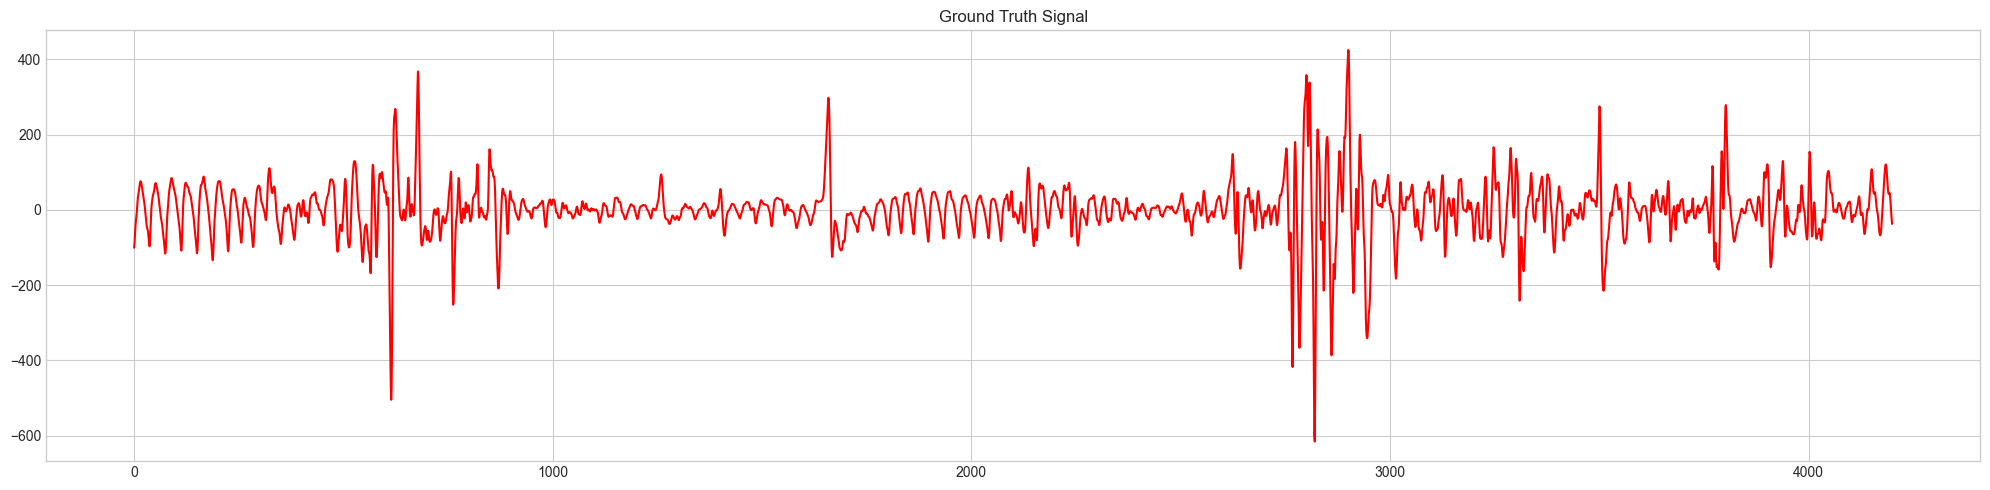

In [18]:
## Plot the Ground Truth
plt.figure(figsize=(20, 5)) 
plt.plot(downsampled_ground_truth, color='red')
plt.title('Ground Truth Signal')
plt.tight_layout()
plt.show()

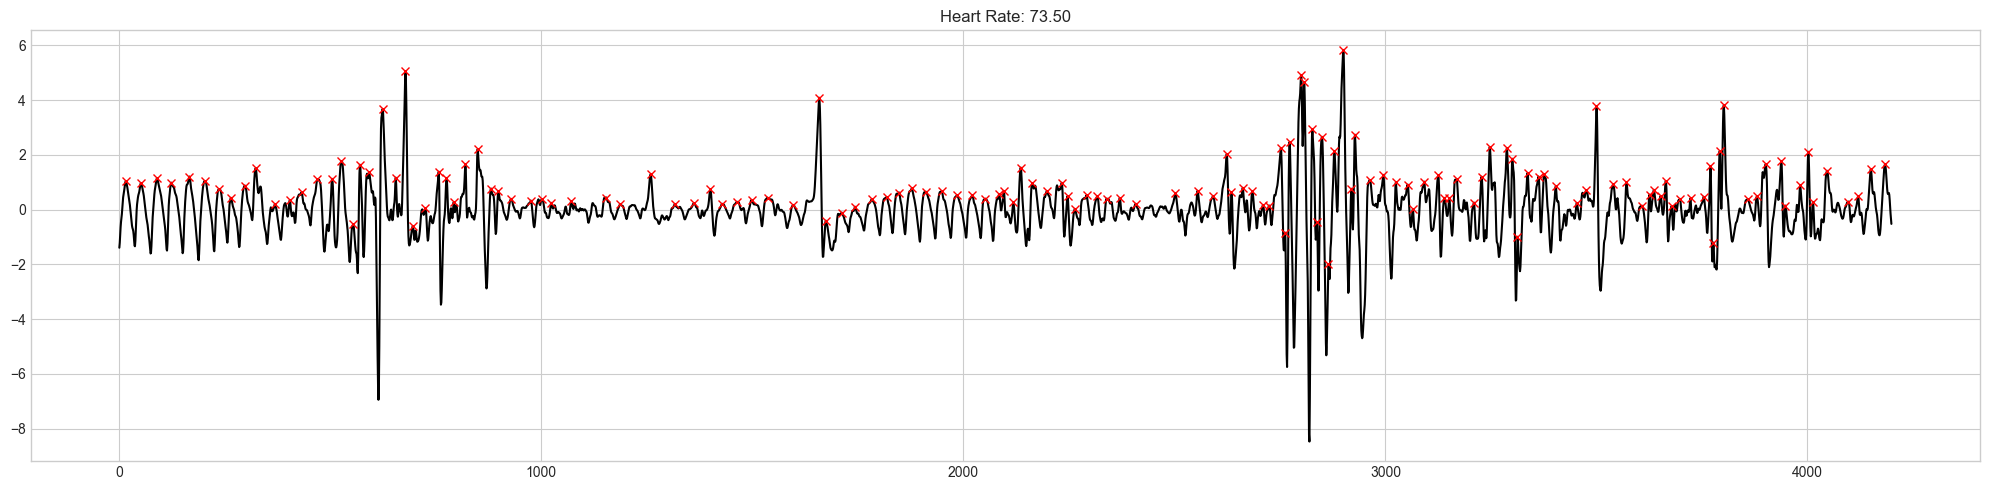

In [19]:
## Normalize the RPPG Signal
downsampled_ground_truth = (downsampled_ground_truth - np.mean(downsampled_ground_truth)) / np.std(downsampled_ground_truth)

## Finds Peak Signal
peaks, _ = signal.find_peaks(
    x=downsampled_ground_truth,
    prominence=0.5,
)

## Calculating the Heart Rate and Show the Result
heart_rate = 60 * len(peaks) / (len(downsampled_ground_truth) / fs)

plt.figure(figsize=(20, 5))
plt.plot(downsampled_ground_truth, color='black')
plt.plot(peaks, downsampled_ground_truth[peaks], 'x', color='red')
plt.title(f'Heart Rate: {heart_rate:.2f}')
plt.tight_layout()
plt.show()

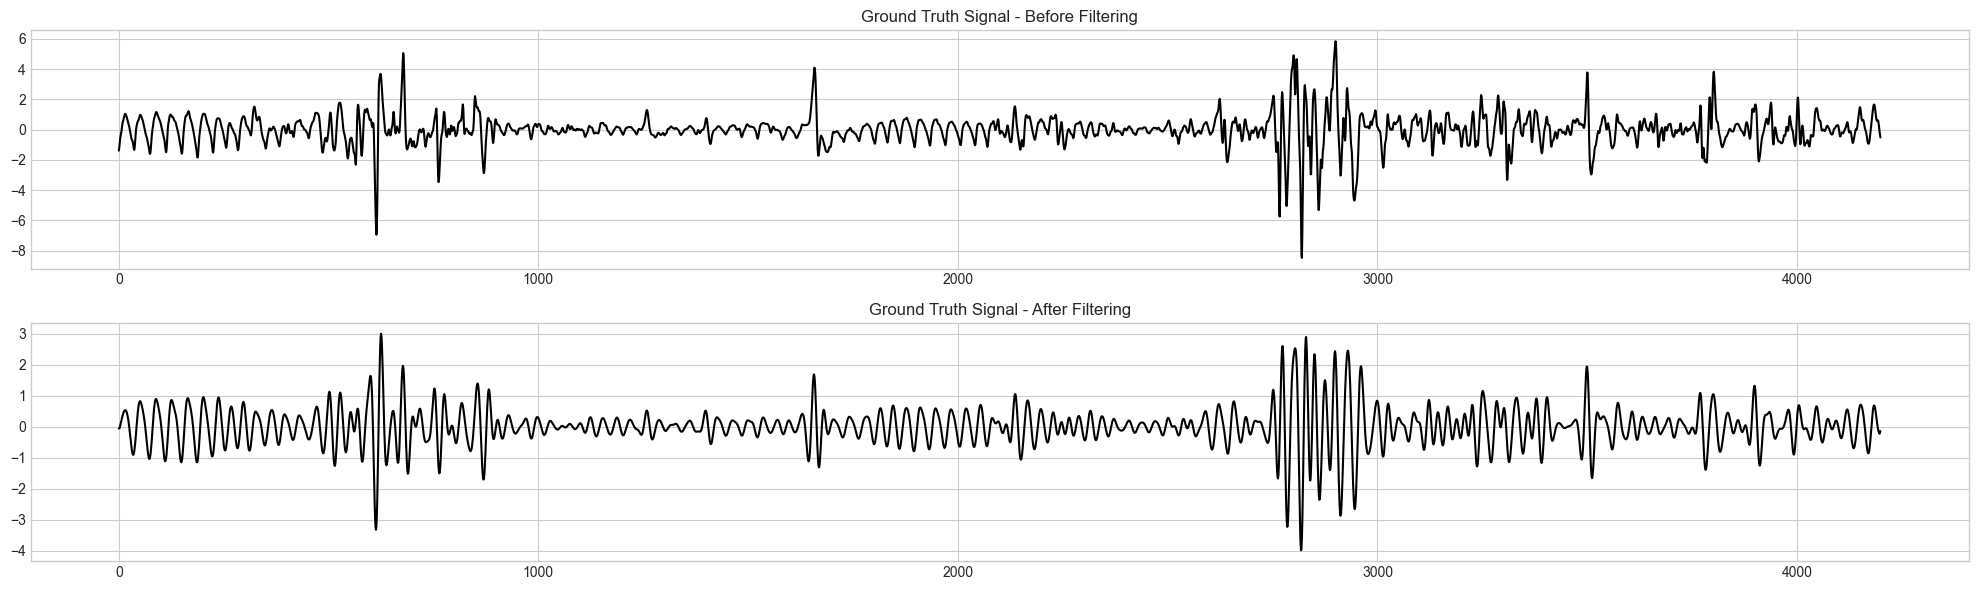

In [20]:
compressed_filtered_ground_truth = preprocess_signal(downsampled_ground_truth, fs=35)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(downsampled_ground_truth, color='black')
ax[0].set_title('Ground Truth Signal - Before Filtering')
ax[1].plot(compressed_filtered_ground_truth, color='black')
ax[1].set_title('Ground Truth Signal - After Filtering')
plt.tight_layout()
plt.show()

---

## Getting the Project Aura
This part require to obtain the RR value from 30 sec signal

Length Peaks: 113
Length RR Signal: 112


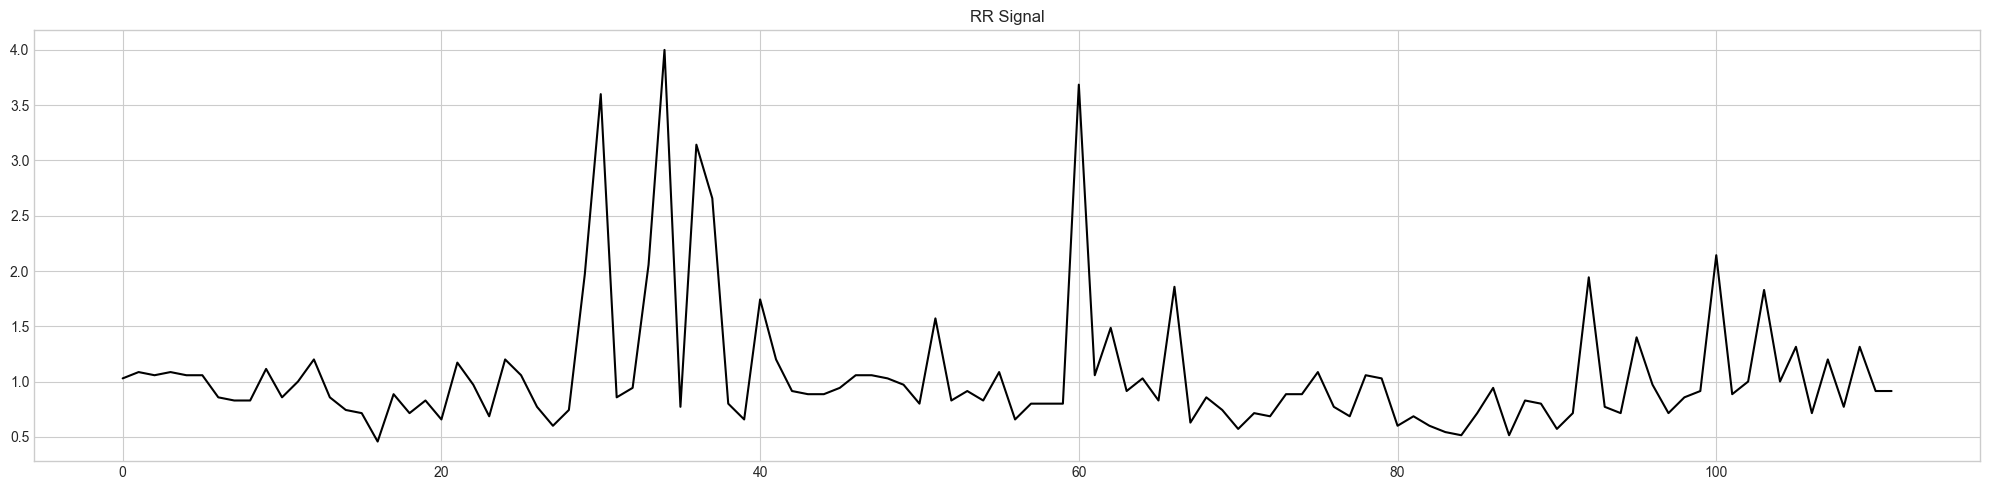

In [21]:
## Getting the RR signal
def detect_peaks(rppg_signal, fs):
    peaks, _ = signal.find_peaks(
        x=rppg_signal,
        prominence=0.5,
    )
    rr_signal = np.diff(peaks) / fs
    return peaks, rr_signal

peaks, rr_signal = detect_peaks(compressed_filtered_ground_truth, fs=35)

## Print Length Peaks and RR Signal
print(f"Length Peaks: {len(peaks)}")
print(f"Length RR Signal: {len(rr_signal)}")

## Plot the RR Signal
plt.figure(figsize=(20, 5))
plt.plot(rr_signal, color='black')
plt.title('RR Signal')
plt.tight_layout()
plt.show()


## Project Aura

In [22]:
from hrvanalysis import get_time_domain_features

## Get the Time Domain Features
time_domain = get_time_domain_features(rr_signal)

time_domain

{'mean_nni': 1.0635204081632652,
 'sdnn': 0.6136129304444158,
 'sdsd': 0.7935845717731634,
 'nni_50': 0,
 'pnni_50': 0.0,
 'nni_20': 0,
 'pnni_20': 0.0,
 'rmssd': 0.7935852396779287,
 'median_nni': 0.8857142857142857,
 'range_nni': 3.5428571428571427,
 'cvsd': 0.7461871286969252,
 'cvnni': 0.5769639451528208,
 'mean_hr': 66739.78853939033,
 'max_hr': 131250.0,
 'min_hr': 15000.0,
 'std_hr': 21785.616614693758}

In [23]:
## Get the Frequency Domain Features
from hrvanalysis import get_frequency_domain_features

freq_domain = get_frequency_domain_features(rr_signal)

freq_domain

c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\hrvanalysis\extract_features.py:434: RuntimeWarning: invalid value encountered in scalar divide
  lf_hf_ratio = lf / hf
c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\hrvanalysis\extract_features.py:435: RuntimeWarning: invalid value encountered in scalar divide
  lfnu = (lf / (lf + hf)) * 100
c:\Users\ACER\miniconda3\envs\codex_astartes\lib\site-packages\hrvanalysis\extract_features.py:436: RuntimeWarning: invalid value encountered in scalar divide
  hfnu = (hf / (lf + hf)) * 100


{'lf': 0.0,
 'hf': 0.0,
 'lf_hf_ratio': nan,
 'lfnu': nan,
 'hfnu': nan,
 'total_power': 0.0,
 'vlf': 0.0}

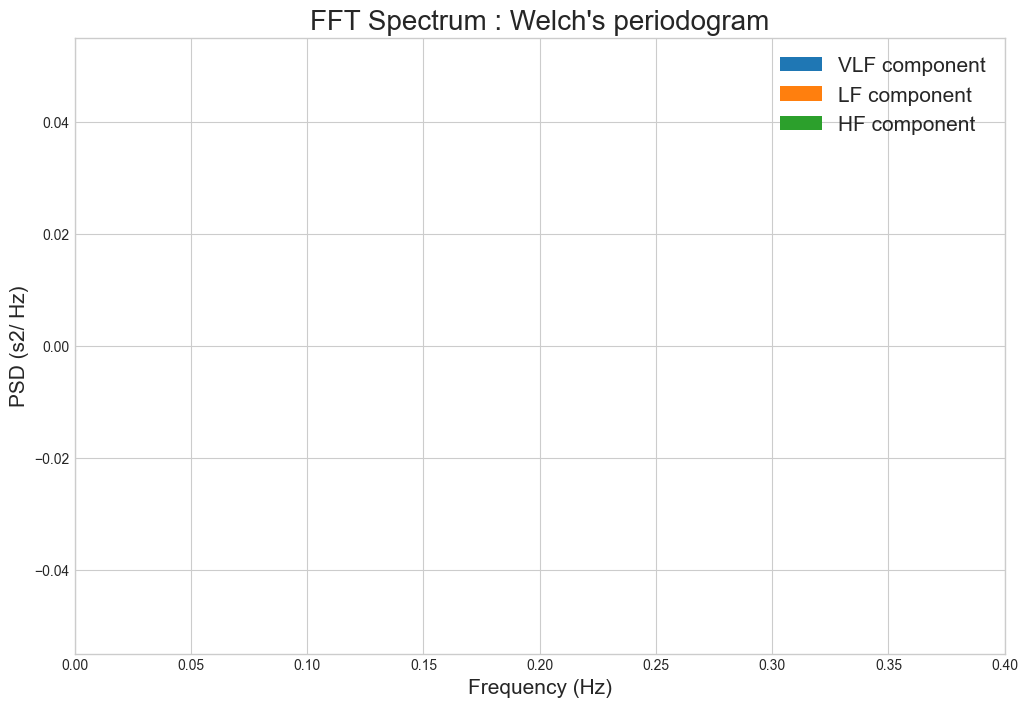

In [24]:
## Plot PSD
from hrvanalysis import plot_psd, plot_distrib

# nn_intervals_list contains integer values of NN-interval

plot_psd(rr_signal, method="welch")
# plot_distrib(rr_signal)
